## Importing Data Notebook and Inputting User Metadata

Code sources:
- https://github.com/dlab-berkeley/Geospatial-Fundamentals-in-Python/blob/master/Geopandas_Intro_F2019_GC.ipynb
- https://rasterio.readthedocs.io/en/stable/

#### Metadata: operating system and directory

Specify operating system:

In [1]:
# get operating system (Windows or Mac) from user
op_user_input = input("What is your operating system?\nEnter w for Windows and m for Mac.")


What is your operating system?
Enter w for Windows and m for Mac.w


In [2]:
# set operating system for workflow
op_system_dict = {'w':'Windows', 'm':'Mac'}
op_system = op_system_dict[op_user_input]
op_system

'Windows'

Set path to master directory:

In [3]:
# Create an object containing the file path to a master folder with the following folders:
    # code
        # 1_importing (This import notebook should be within this sub-folder)
        # 2_cleaning
        # 3_processing
        # 4_exploration
        # 5_analysis
        # 6_output
    # data
        # raw_data
        # processed_data
        
# Set the object `master` to your local file path of the master folder
master = 'C:/Users/theaa/Desktop/Data Science Pedagogy Resources/Python/Human_Mobility_Project/Human_Mobility_Project'
# master = '/Users/katewetstone/Desktop/CYPLAN 257 Data Science Human Mobility/Human_Mobility_Project'

In [4]:
user_ans = input('Is this the correct master directory? Type Y or N\n'+master)

Is this the correct master directory? Type Y or N
C:/Users/theaa/Desktop/Data Science Pedagogy Resources/Python/Human_Mobility_Project/Human_Mobility_ProjectY


In [5]:
if user_ans == 'N':
    master = input('Enter the correct path to the master directory')

#### Metadata: PCA datasets and files

Input metadata about datasets to be used in PCA. Specify the list of PCA datasets to be used and the direction of vulnerability for each in the form of a dictionary. Dictionary format: `{'dataset_zipfile_name':direction of vulnerability}`

For direction of vulnerability
- 1: higher value indicates higher vulnerability (eg. infant mortality)
- -1: lower value indicates higher vulnerability (eg. median income)

To get the direction of vulnerability for a given dataset:
`pca_data_metadata['pca_data_name']` (eg. `pca_data_metadata['travel_time']` returns 1)

In [6]:
pca_data_metadata = {'travel_time':1,
                     'infant_mort':1,
                    'val_prod':-1,
                    'val_prod_per_ha':-1}
pca_data_names = list(pca_data_metadata.keys())

print(pca_data_metadata)
print(pca_data_names)

{'travel_time': 1, 'infant_mort': 1, 'val_prod': -1, 'val_prod_per_ha': -1}
['travel_time', 'infant_mort', 'val_prod', 'val_prod_per_ha']


Enter a list of zipfile names containing the data required for pca and for country borders:

In [7]:
myfiles = ('TravelTime_50k.zip', 
           'World_Country_Borders.zip', 
            'PovMap_Global_Infant_Mortality.zip', 
           'val_prod.zip')

In [8]:
# import packages necessary besides geopandas and rasterio
from random import randint
import numpy as np
import math
import warnings
import sklearn
import matplotlib.pyplot as plt

### Installing and Importing Necessary Packages

Geopandas works for vector data. For raster data, use rasterio (see next section).

First, install Homebrew so that the `!brew install spatialindex` command  works. `spatialindex` is a dependency of `rtree`, which is a dependency of `geopandas`. To install Homebrew open a new Terminal window and enter the following command:

`!ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" < /dev/null 2> /dev/null`

When it prompts for your password, type in your computer's password and press Enter. Your password won't show up typed onto the screen but is still being entered.

In [72]:
# !ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" < /dev/null 2> /dev/null

Install libraries:

In [73]:
# Install os
if op_system == 'Windows' :
    !pip install os

# Install zipfile
if op_system == 'Windows' :
    !pip install zipfile 

# Install wget
!pip install wget
# Install pysal
!pip install pysal
# Install mapclassify
!pip install mapclassify
# Install geopy
!pip install geopy

# Install Geopandas dependencies
!pip install fiona 
!pip install shapely 
!pip install pyproj 
!pip install spatialindex
!pip install rtree

# Install Geopandas
!pip install geopandas
# Install descartes - Geopandas requirement
!pip install descartes

ERROR: Could not find a version that satisfies the requirement spatialindex (from versions: none)
ERROR: No matching distribution found for spatialindex


Geopandas can also be installed directly from github. This still requires installing geopandas dependencies separately (`pandas fiona shapely pyproj rtree`)

To install directly from github: `!pip install git+git://github.com/geopandas/geopandas.git`

Import libraries:

In [124]:
from __future__ import division

# Import os and zipfile for Windows
import os
import zipfile

# Import wget    
import wget

# geopandas dependencies
import pandas as pd
import fiona 
import shapely
import pyproj
import rtree

# Import geopandas, mapclassify, and matplotlib
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping
from matplotlib import pyplot

import matplotlib as mpl
from descartes import PolygonPatch
import geopy.distance

### Installing and Importing Rasterio

References: 
- https://rasterio.readthedocs.io/en/stable/
- https://rasterio.readthedocs.io/en/stable/quickstart.html#reading-raster-data

Note that geopandas only works for vector data.

In [75]:
if op_system == 'Mac' :
    !pip install rasterio

In [76]:
if op_system == 'Windows' :
    !conda config --add channels conda-forge
    !conda install rasterio

In [119]:
!pip install affine
!pip install mercantile

In [128]:
import rasterio
import rasterio.features
import rasterio.warp
import rasterio.mask
import rasterio.plot
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT
from rasterio.crs import CRS
from rasterio import shutil as rio_shutil

import affine
from affine import Affine
import mercantile

## Fetch and Unzip Raw Data

Fetch data files with `wget`

In [11]:
# Set our current directory to the master folder
os.chdir(master)

See the list saved as `myfiles` in the metadata section:

In [12]:
myfiles

('TravelTime_50k.zip',
 'World_Country_Borders.zip',
 'PovMap_Global_Infant_Mortality.zip',
 'val_prod.zip')

In [13]:
data_path = 'data/raw_data'

FLAG:
- This was giving errors  because the folder for raw didn't exist. I made the data/raw_data folder and added a placeholder txt file that we may need to keep in there even when we dump all the other stuff (I think empty folders can't exist on github)
- in the wget.download, I had to change the link (see below) for it to download correctly as a zipfile. before it wasn't able to recognize the files as zip files even after they downloaded

In [14]:
prefix = 'https://github.com/AaronScherf/Southern_Africa_Data/blob/master/'

for f in myfiles:
    wget.download(prefix+f+'?raw=true', out = data_path)

Unzip the data files

In [15]:
for f in myfiles:
    with zipfile.ZipFile(data_path+'/'+f, 'r') as zip_ref:
        zip_ref.extractall(data_path)

In [16]:
if 'CELL5M.zip' in myfiles:
    dir_name = master + '/' + data_path + '/CELL5M/Raster'
    extension = ".zip"

    os.chdir(dir_name) # change directory from working dir to dir with files

    for item in os.listdir(dir_name): # loop through items in dir
        if item.endswith(extension): # check for ".zip" extension
            file_name = os.path.abspath(item) # get full path of files
            zip_ref = zipfile.ZipFile(file_name) # create zipfile object
            zip_ref.extractall(dir_name) # extract file to dir
            zip_ref.close() # close file
            os.remove(file_name) # delete zipped file

In [17]:
# Set our current directory to the master folder
os.chdir(master)

## Reading in Vector Data with GeoPandas

Import the shapefile for country borders. Steps needed:
1. Import shapefile (done)
2. Change the bounds to only include southern Africa (to do)

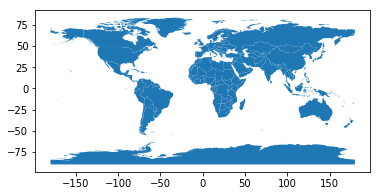

In [18]:
# read in borders shapefile
country_borders = gpd.read_file(data_path+'/'+
                                'World_Country_Borders/ne_50m_admin_0_countries.shp') 
# visualize country borders
country_borders.plot()

In [19]:
print("Country Borders CRS", country_borders.crs)

Country Borders CRS {'init': 'epsg:4326'}


In [20]:
southern_africa_countries = ('South Africa', 
                             'Angola', 
                             'Botswana',
                             'Lesotho',
                             'eSwatini',
                             'Namibia',
                             'United Republic of Tanzania',
                             'Zambia',
                             'Zimbabwe',
                             'Madagascar',
                             'Democratic Republic of the Congo',
                             'Mozambique',
                             'Malawi'
                            )

sum(country_borders['ADMIN'].isin(southern_africa_countries)) == len(southern_africa_countries)

True

In [21]:
southern_africa_borders = country_borders[country_borders['ADMIN'].isin(southern_africa_countries)]

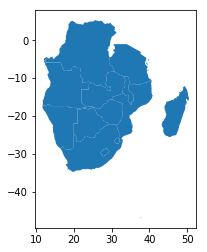

In [22]:
southern_africa_borders.plot()

In [23]:
if op_system == 'Windows':
    # FLAG: aaron, check that this displays the same way within an if 
#     statement. also check command three chunks down
    southern_africa_borders.unary_union.envelope
elif op_system == 'Mac':
    print(southern_africa_borders.bounds)

In [91]:
max_lat = max(southern_africa_borders.bounds['maxx']) # right bound
min_lat = min(southern_africa_borders.bounds['minx']) # left bound
max_long = max(southern_africa_borders.bounds['maxy']) # top bound
min_long = min(southern_africa_borders.bounds['miny']) # bottom bound

In [92]:
upper_left = [min_lat,max_long]
upper_right = [max_lat,max_long]
lower_right = [max_lat,min_long]
lower_left = [min_lat,min_long]

In [93]:
if op_system == 'Windows':
    southern_africa_borders.unary_union[1] | southern_africa_borders.unary_union[7]

In [29]:
if op_system == 'Mac':
    southern_africa_box = shapely.geometry.box(
        min_lat, min_long, max_lat, max_long, ccw=True)
elif op_system == 'Windows':
    southern_africa_box = southern_africa_borders.unary_union.envelope

FLAG: I changed the code for windows as well so both save the necessary object as 'southern_africa_box', so there are fewer places where we need to split mac and windows for the workflow. before, the object for windows was saved as southern_africa_box.union and border_box.union. I changed it both above and when writing to a new shapefile below.

I saved a checkpoint before making the changes so they should still be accessible if it stops working for you.

In [49]:
# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile of the boundary box
with fiona.open('data/raw_data/border_box.shp', 'w', 'ESRI Shapefile', schema) as c:
  ## If there are multiple geometries, put the \"for\" loop here\n",
    c.write({
        'geometry': mapping(southern_africa_box),
        'properties': {'id': 123},
    })

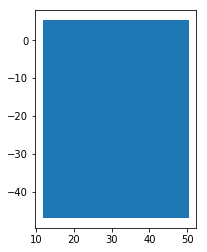

In [50]:
# read in borders shapefile
border_box = gpd.read_file(data_path+'/'+
                                'border_box.shp') 
# visualize country borders
border_box.plot()

FLAG: for me, this doesn't give an outline of the countries, it just gives a rectangle. was that the case before / is that a problem?

No that's the goal.

## Read in Raster Data with Rasterio

Read in the data for variables to use in the principal component analysis.

FLAG: change the name of the zipfile to the name we want to save the saved version as (will be easier for when we incorporate data processing pipeline)

In [32]:
# display list of datasets
pca_data_names

['travel_time', 'infant_mort', 'val_prod', 'val_prod_per_ha']

In [34]:
# Save paths for all datasets
# FLAG: turn into a for loop once the names of paths matches 
#                   what we want them to be saved as
Paths = list()
Paths.append(data_path+'/'+'TravelTime_50k/Traveltime_50k.tif')
Paths.append(data_path+'/'+
             'PovMap_Global_Infant_Mortality/povmap_global_subnational_infant_mortality_rates_v2.tif')
Paths.append(data_path+'/'+'val_prod.tif')
Paths.append(data_path+'/'+'val_prod_per_ha.tif')

# Create a dataframe to store pca data through pipeline
pca_data = pd.DataFrame({'path':Paths},
                       index = pca_data_names)
pca_data

,path
travel_time,data/raw_data/TravelTime_50k/Traveltime_50k.tif
infant_mort,data/raw_data/PovMap_Global_Infant_Mortality/p...
val_prod,data/raw_data/val_prod.tif
val_prod_per_ha,data/raw_data/val_prod_per_ha.tif


In [35]:
# Create a list with raster data
rasters = list()
for name in pca_data_names:
    rasters.append(rasterio.open(pca_data.loc[name,'path']))

# add as a column to the pca dataframe
pca_data['raster'] = rasters

# To access one raster data file
pca_data.loc['travel_time','raster']

<open DatasetReader name='data/raw_data/TravelTime_50k/Traveltime_50k.tif' mode='r'>

In [36]:
# Create a list with raster metadata
metadata = list()
for name in pca_data_names:
    metadata.append(pca_data.loc[name,'raster'].profile)
    
# add as a column to pca dataframe
pca_data['metadata'] = metadata

# To access one raster metadata file
pca_data.loc['travel_time','metadata']

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 828, 'height': 742, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.08333333333329998, 0.0, -17.499999999666578,
       0.0, -0.0833333333333, 26.9999999998646), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

travel_time
infant_mort


C:\Users\theaa\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\image.py:399: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
C:\Users\theaa\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\image.py:404: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact
C:\Users\theaa\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\image.py:441: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)
C:\Users\theaa\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


val_prod
val_prod_per_ha


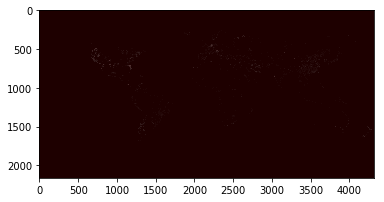

In [37]:
for name in pca_data_names:
    print(name)
    pyplot.imshow(pca_data.loc[name,'raster'].read(1), cmap='pink')
    pyplot.savefig(name+'_raw.png')
#    pyplot.show()

Next step: use dataset.transform to map pixel locations. See https://rasterio.readthedocs.io/en/stable/quickstart.html#reading-raster-data

All datasets for PCA should use the same coordinate reference system, `EPSG:4326`.

In [102]:
def check_crs(datasets, crs='EPSG:4326'):
    # Checks that all datasets use the same coordinate reference system
    # Returns true if all datasets use the crs specified
    check = True
    for dataset in datasets:
        if dataset.crs != crs:
            print(dataset.name)
            print(dataset.crs)
            check = False
    return check

check_crs(pca_data['raster'])

True

## Warping Rasters into the Same Resolution and CRS

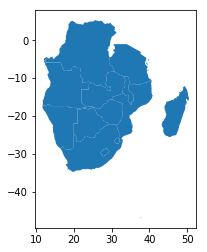

In [94]:
southern_africa_borders.plot()

In [93]:
bounds = list()
for name in pca_data_names:
    bounds.append(list(pca_data.loc[name,'raster'].bounds))
bounds.append(list(border_box.bounds.iloc[0,:]))
bounds = pd.DataFrame(bounds, columns = ('minx','miny','maxx','maxy'))
bounds

,minx,miny,maxx,maxy
0,-17.50000,-34.833333,51.500000,27.000000
1,-180.00000,-59.481222,180.000000,83.627112
2,-180.00000,-89.999280,179.998560,90.000000
3,-180.00000,-89.999280,179.998560,90.000000
4,11.72168,-46.962891,50.482715,5.312109


In [100]:
# Find the intersection of all raster and boundary files
# NOTE: May not work in other hemisphere quadrants
inter_bounds = (bounds.iloc[:,0].max(),
                bounds.iloc[:,1].max(),
                bounds.iloc[:,2].min(),
                bounds.iloc[:,3].min())
inter_bounds

(11.7216796875, -34.833333333443996, 50.48271484375002, 5.3121093749999915)

In [129]:
input_files = (pca_data['path'])

# Destination CRS
dst_crs = CRS.from_epsg(4326)

# These coordiantes are in Web Mercator
dst_bounds = inter_bounds

# Output image dimensions

bottom_left = (inter_bounds[0], inter_bounds[1]) 
bottom_right = (inter_bounds[2], inter_bounds[1])

dst_width = geopy.distance.distance(bottom_left, bottom_right).km

top_left = (inter_bounds[0],inter_bounds[3])

dst_height = geopy.distance.distance(top_left, bottom_left).km

print(dst_width, dst_height)

# Output image transform
left, bottom, right, top = dst_bounds
xres = (right - left) / dst_width
yres = (top - bottom) / dst_height
dst_transform = affine.Affine(xres, 0.0, left,
                              0.0, -yres, top)

vrt_options = {
    'resampling': Resampling.cubic,
    'crs': dst_crs,
    'transform': dst_transform,
    'height': dst_height,
    'width': dst_width,
}

for path in input_files:

    with rasterio.open(path) as src:

        with WarpedVRT(src, **vrt_options) as vrt:

            # At this point 'vrt' is a full dataset with dimensions,
            # CRS, and spatial extent matching 'vrt_options'.

            # Read all data into memory.
            data = vrt.read()

            # Process the dataset in chunks.  Likely not very efficient.
            for _, window in vrt.block_windows():
                data = vrt.read(window=window)

            # Dump the aligned data into a new file.  A VRT representing
            # this transformation can also be produced by switching
            # to the VRT driver.
            directory, name = os.path.split(path)
            outfile = os.path.join(directory, 'aligned-{}'.format(name))
            rio_shutil.copy(vrt, outfile, driver='GTiff')

4298.244862722446 4372.501507212104


In [134]:
for file in pca_data_names:
    directory, name = os.path.split(pca_data.loc[file,'path'])
    pca_data.loc[file,'aligned_path'] = os.path.join(directory, 'aligned-{}'.format(name))

In [135]:
# Create a list with raster data
al_rasters = list()
for name in pca_data_names:
    al_rasters.append(rasterio.open(pca_data.loc[name,'aligned_path']))

# add as a column to the pca dataframe
pca_data['al_raster'] = al_rasters

pca_data.loc['travel_time','al_raster']

<open DatasetReader name='data/raw_data/TravelTime_50k\aligned-Traveltime_50k.tif' mode='r'>

In [138]:
for name in pca_data_names:
    print(pca_data.loc[name,'al_raster'].bounds)

BoundingBox(left=11.7216796875, bottom=-34.82872882295539, right=50.48050670231176, top=5.3121093749999915)
BoundingBox(left=11.7216796875, bottom=-34.82872882295539, right=50.48050670231176, top=5.3121093749999915)
BoundingBox(left=11.7216796875, bottom=-34.82872882295539, right=50.48050670231176, top=5.3121093749999915)
BoundingBox(left=11.7216796875, bottom=-34.82872882295539, right=50.48050670231176, top=5.3121093749999915)


travel_time
infant_mort
val_prod
val_prod_per_ha


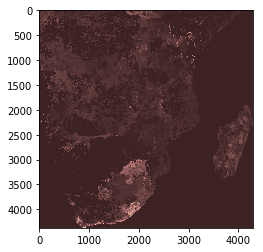

In [137]:
for name in pca_data_names:
    print(name)
    pyplot.imshow(pca_data.loc[name,'al_raster'].read(1), cmap='pink')
    pyplot.savefig(name+'_aligned.png')
#    pyplot.show()

### Masking the Outline of Southern Africa from Raster files using Shapefile Boundaries

Code Source: 
Clipping Shapefile Vectors - https://www.earthdatascience.org/courses/earth-analytics-python/spatial-data-vector-shapefiles/clip-vector-data-in-python-geopandas-shapely/

Masking Rasters using Vector Geometry - https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html

In [139]:
# for raster in raster_data_paths:
for raster in pca_data['aligned_path']:

    with fiona.open("data/raw_data/border_box.shp", "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(str(raster[:-4]) + '_mask.tif', "w", **out_meta) as dest:
        dest.write(out_image)

In [141]:
# create list of masked data
Masked = list()
for name in pca_data_names:
    Masked.append(rasterio.open(
        pca_data.loc[name,'aligned_path'][:-4] + '_mask.tif'))

# add column for masked data to dataframe
pca_data['masked'] = Masked

In [146]:
# create list of band data
raster_bands = list()
for name in pca_data_names:
    raster_bands.append(pca_data.loc[name,'masked'].read(1))

# add column for band data to dataframe
pca_data['band'] = raster_bands

In [147]:
# create list of dataframes
raster_dfs = list()
for name in pca_data_names:
    raster_dfs.append(pd.DataFrame(pca_data.loc[name,'band']))

# add column for dfs to pca_data
pca_data['df'] = raster_dfs

In [150]:
# Check that all raster masks have same shape
shapes = list()
for name in pca_data_names:
    shapes.append(list(pca_data.loc[name,'df'].shape))

len(np.unique(shapes)) == 2

True

In [152]:
# Check that top left cell is identical for all transformed rasters
top_left = list()
for name in pca_data_names:
    top_left.append(pca_data.loc[name,'masked'].transform * (0,0))

# Confirm that top left pixel is the same for all rasters
top_left=np.array(top_left)
len(np.unique(top_left)) == 2

True

Note: Which of the data forms do we need to save and access? If there's ones that are just an intermediate step and we won't use later, we don't have to add them as columns to the data frame (or we can delete the column after we use it)

AS: Response: I think the DataFrame version of the first band is the only thing we will need for PCA. Keeping the raster files and bands could be helpful for plotting later though. So we should only have one column per variable type for the final PCA dataframe.

We still need to figure out how to convert the PCA-ready dataframe back into a map though so we can visualize the end result.

KW: Ok I'll keep the raster, masked, and df in the pca_data dataframe for us to reference. the df version is the only one I'll put into the actual PCA dataframe

### Address missing and placeholder values

Use each dataset's README file to standardize treatment of missing and placeholder (ie. ocean) values across datasets. Replace all missing values with NaN.

In [153]:
def explore_codevals(dataset_name):
    df = pca_data.loc[dataset_name,'df']
    min_val = df.min().min()
    max_val = df.max().max()
    count_na = np.count_nonzero(df.isna())
    count_neg = np.count_nonzero(df < 0)
    count_min = np.count_nonzero(df == min_val)
    pct_neg = round(100*count_neg / df.size)
    
    return pd.DataFrame([[dataset_name, min_val, max_val, 
                         count_na, count_neg, count_min, pct_neg]],
        columns=['data','min','max','count_na',
                 'count_neg','count_min','pct_neg'],)

In [154]:
codeval_df = pd.DataFrame()
for name in pca_data_names:
    codeval_df = pd.concat([codeval_df, 
                           explore_codevals(name)],
                          ignore_index=True)
codeval_df = codeval_df.set_index('data')

In [155]:
codeval_df

,min,max,count_na,count_neg,count_min,pct_neg
data,,,,,,
travel_time,-3.402823e+38,6.118075e+01,0,6687627,6687474,36.0
infant_mort,-1.797693e+308,5.513881e+03,0,6872767,6577146,37.0
val_prod,-3.242018e+06,5.029973e+07,0,12028238,1,64.0
val_prod_per_ha,-5.688025e+02,1.831456e+04,0,11992278,1,64.0


Notes about file-specific value coding:
- So far, no datasets have NA values
- For every dataset, there are no other negative values besides the minimum
- Datasets should definitely be normalized before PCA (there is a big range in the max values).

In each dataset, we will probably be able to just replace all of the negative values with whatever missing placeholder we want to use. 

The difference in number of negative values is not just due to granularity/pixel size - the percentage of negative values is different, so datasets are missing data for different areas.

In [156]:
# add column with cleaned dfs
cleaned_dfs = list()

# replace all negative values with NaN
for name in pca_data_names:
    df = pca_data.loc[name,'df']
    df = df.replace(codeval_df.loc[name,'min'], np.nan)
    cleaned_dfs.append(df)

# add to pca_data
pca_data['cleaned_df'] = cleaned_dfs

In [157]:
# check that it worked
name = 'travel_time'
pca_data.loc[name,'cleaned_df'].loc[0:4,0:4]

,0,1,2,3,4
0,4.273767,4.082542,3.856609,3.613127,3.369257
1,4.755324,4.537933,4.278258,3.995879,3.710376
2,5.246874,5.015164,4.735840,4.430010,4.118777
3,5.783381,5.546477,5.258318,4.940850,4.616018
4,6.370913,6.135571,5.846504,5.525992,5.196315


In [158]:
pca_data.loc[name,'df'].loc[0:4,0:4]

,0,1,2,3,4
0,4.273767,4.082542,3.856609,3.613127,3.369257
1,4.755324,4.537933,4.278258,3.995879,3.710376
2,5.246874,5.015164,4.735840,4.430010,4.118777
3,5.783381,5.546477,5.258318,4.940850,4.616018
4,6.370913,6.135571,5.846504,5.525992,5.196315


## Write New Raster Files with Processed Data

In [160]:
for name in pca_data_names:
    with fiona.open("data/raw_data/border_box.shp", "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(pca_data.loc[name,'aligned_path']) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
 
    with rasterio.open(pca_data.loc[name,'aligned_path'][:-4]+'_proc.tif', 'w', **out_meta) as dst:
        dst.write(np.array(pca_data.loc[name,'cleaned_df']), 1)

In [161]:
# create list of processed raster data
processed = list()
for name in pca_data_names:
    processed.append(rasterio.open(
        pca_data.loc[name,'aligned_path'][:-4] + '_proc.tif'))

# add column for masked data to dataframe
pca_data['processed'] = processed

travel_time


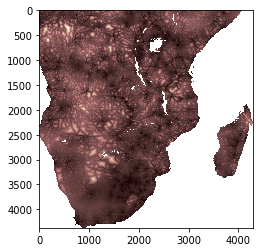

infant_mort


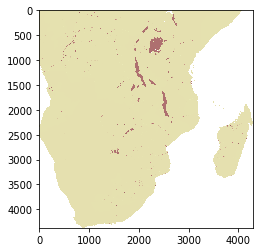

val_prod


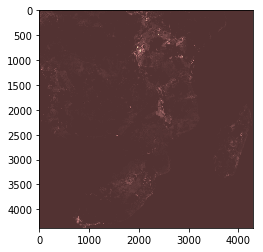

val_prod_per_ha


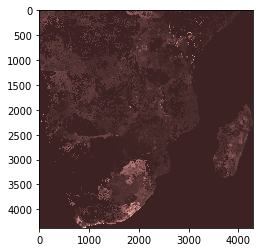

In [162]:
for name in pca_data_names:
    print(name)
    pyplot.imshow(pca_data.loc[name,'processed'].read(1), cmap='pink')
    pyplot.savefig(name+'_proc.png')
    pyplot.show()

### Flag: Need to mask out water, then standardize before PCA

## Create PCA dataframe

Merge all PCA variables into one dataframe with full coordinates as index

In [163]:
# Define functions for reshaping banded data df into PCA format
def pca_melt(dataset_name):
    # preps the dataframe to be melted by adding columns for x and y
    df = pca_data.loc[dataset_name,'cleaned_df']
    
    # argument: dataframe with x coord as index as y coords as columns
    nrows, ncols = df.shape
    nrows -= 1; ncols -= 1

    # convert index to a column to melt
    re_df = df.reset_index().rename(columns={'index':'x'})
    re_df = pd.melt(re_df, id_vars=['x'],
                    value_vars=range(0,ncols),
                    var_name='y',
                    value_name = dataset_name)
    
    # turn x and y columns into a coordinate index
    re_df['coords'] = re_df['x'].astype(str)+','+re_df['y'].astype(str)
    re_df = re_df.set_index('coords')
    
    return re_df

def save_coord_ranges(coord_ranges_dataframe,pca_df,dataset_name):
    # ARGS: dataframe with rows min x, max y, min y, max y,
        # melted dataframe for PCA with columns labeled 'x' and 'y'
    # adds a column to coord_ranges with info for the given pca dataframe
    coord_ranges_dataframe[dataset_name]=[min(pca_df['x']),
                                     max(pca_df['x']),
                                     min(pca_df['y']),
                                     max(pca_df['y'])]
    
    return coord_ranges

def check_pca_reshape(re_df, n=15):
    # check that the raw and reshaped dfs have the same values 
    # for a random set of n coordinates
    df = pca_data.loc[dataset_name,'cleaned_df']
    check = True
    for i in range(0,n):
        x = randint(0, df.shape[0]-1); y = randint(0, df.shape[1]-1)
        raw_val = df.loc[x][y]
        new_val = re_df.loc[str(x)+','+str(y)][dataset_name]
        if (raw_val != new_val) & (not math.isnan(new_val)):
            check = False
            print('Error for coordinate: (',x,',',y,
                  ')\nraw:',raw_val,'\nnew:',new_val)
    return check

Process all of the datasets for PCA using the functions defined above:

In [164]:
pca_dfs = list()

# create dataframe to save coordinate ranges
coord_ranges = pd.DataFrame(index=['minx','maxx','miny','maxy'])

# iterate through datasets and reshape for PCA
for dataset_name in pca_data_names:
    # melt dataframe
    pca_df = pca_melt(dataset_name)
    # save the coordinate ranges
    coord_ranges = save_coord_ranges(coord_ranges, pca_df, dataset_name)
    # check that the resulting dataframe is correct
    check = check_pca_reshape(pca_df)
    if not check:
        print('Error in PCA reshape')
    # add the pca dataframe to the list
    pca_dfs.append(pca_df)

pca_data['pca_df'] = pca_dfs

In [165]:
coord_ranges

,travel_time,infant_mort,val_prod,val_prod_per_ha
minx,0,0,0,0
maxx,4371,4371,4371,4371
miny,0,0,0,0
maxy,4296,4296,4296,4296


In [166]:
# check that it worked
name = 'travel_time'
pca_data.loc[name,'pca_df'].loc['0,1':'4,1']

,x,y,travel_time
coords,,,
"0,1",0,1,4.082542
"1,1",1,1,4.537933
"2,1",2,1,5.015164
"3,1",3,1,5.546477
"4,1",4,1,6.135571


In [167]:
pca_data.loc[name,'cleaned_df'].loc[0:4,[1]]

,1
0,4.082542
1,4.537933
2,5.015164
3,5.546477
4,6.135571


#### Use the x and y coordinate columns to crop datasets to same shape

In [168]:
# determine minimum and maximum for x and y
all_minx = max(coord_ranges.loc['minx'])
all_maxx = min(coord_ranges.loc['maxx'])
all_miny = max(coord_ranges.loc['miny'])
all_maxy = min(coord_ranges.loc['maxy'])

print('x range:',all_minx,all_maxx,
      '\ny range:',all_miny,all_maxy)

if (all_minx != 0) | (all_miny != 0):
    warnings.warn('One of the minimum coordinates is not zero')

x range: 0 4371 
y range: 0 4296


In [169]:
# crop all datasets
new_coord_ranges = pd.DataFrame(index=['minx','maxx','miny','maxy'])
cropped_pca_dfs = list()

for name in pca_data_names:
    df = pca_data.loc[name,'pca_df']
    df = df[(df['x']<=all_maxx) & (df['y']<=all_maxy)]
    new_coord_ranges = save_coord_ranges(coord_ranges, df, name)
    cropped_pca_dfs.append(df)

pca_data['cropped_pca_df'] = cropped_pca_dfs

In [170]:
new_coord_ranges

,travel_time,infant_mort,val_prod,val_prod_per_ha
minx,0,0,0,0
maxx,4371,4371,4371,4371
miny,0,0,0,0
maxy,4296,4296,4296,4296


#### Account for the direction of vulnerability:
Change the values so that in each dataset, higher number indicates higher vulnerability. 

FLAG: could we do this by multiplying the numbers by -1 if the direction of vulnerbility is opposite? or do all of the values have to be positive? Currently approaching as a reflection around the median or average of the dataset instead of around 0 (making negative), because then the magnitude varies in the same direction for all datasets.

FLAG: are we sure we need to do this? I think we might not - PCA operates based on the direction of the greatest variation. 

#### Merge individual dataframes into one PCA dataset

In [171]:
all_pca_data=pd.DataFrame()
for name in pca_data_names:
    df = pca_data.loc[name,'cropped_pca_df'][[name]]
    all_pca_data=all_pca_data.merge(df,how='outer',
                                    left_index=True,right_index=True,
                                   validate='one_to_one')

In [173]:
# check for correctness
all_pca_data.loc['0,1':'5,1']

,travel_time,infant_mort,val_prod,val_prod_per_ha
coords,,,,
"0,1",4.082542,49.958333,4.768397e+05,892.792480
"1,1",4.537933,49.958333,5.255877e+05,891.282837
"2,1",5.015164,49.958333,6.028492e+05,890.856384
"3,1",5.546477,49.958333,7.302448e+05,890.257080
"4,1",6.135571,49.958333,9.008525e+05,889.069580
"5,1",6.770277,49.958333,1.098508e+06,887.426147


In [174]:
name='val_prod_per_ha'
pca_data.loc[name,'cropped_pca_df'].loc['0,1':'5,1']

,x,y,val_prod_per_ha
coords,,,
"0,1",0,1,892.792480
"1,1",1,1,891.282837
"2,1",2,1,890.856384
"3,1",3,1,890.257080
"4,1",4,1,889.069580
"5,1",5,1,887.426147


In [175]:
all_pca_data.shape

(18786484, 4)

## Conduct PCA

Normalize the values in the PCA dataframe

FLAG: can't have NA values when normalizing, but will count as data if we fill it with zeros. I solved this by getting rid of any rows with NA data. 

In [176]:
# remove all rows with NA data
all_pca_data = all_pca_data.dropna(axis=0)
print(all_pca_data.shape)
coords_included = all_pca_data.index.tolist()
# FLAG: visualize all of the coordinates still included. what's the best 
# format for me to save them in for them to be visualized?
all_pca_data.head()

(12074292, 4)


,travel_time,infant_mort,val_prod,val_prod_per_ha
coords,,,,
"0,0",4.273767,49.958333,532269.2500,890.789246
"1,0",4.755324,49.958333,582659.0625,889.435852
"2,0",5.246874,49.958333,664462.6250,889.147888
"3,0",5.783381,49.958333,800530.9375,888.697754
"4,0",6.370913,49.958333,983195.8750,887.681824


In [177]:
# normalize columns of the dataframe
pca_matrix = np.matrix(all_pca_data)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(pca_matrix)
all_pca_data_norm = scaler.transform(pca_matrix)

all_pca_data_norm[0:5]

array([[-0.42098361,  0.09678842,  0.24421486,  0.63763593],
       [-0.32917402,  0.09678842,  0.29648808,  0.63583732],
       [-0.23545936,  0.09678842,  0.38134919,  0.63545462],
       [-0.13317334,  0.09678842,  0.52250329,  0.63485641],
       [-0.02115949,  0.09678842,  0.71199564,  0.63350627]])

Perform PCA calculation

In [178]:
u,s,vt = np.linalg.svd(all_pca_data_norm, full_matrices=False)

## Analyze PCA Results

In [179]:
def variance_captured(s, i):
    # returns the proportion of variance captured by pc i
    return s[i-1]**2 / np.sum(s**2)

def variance_captured_first_k(s, k):
    # returns the proportion of variance captured by pcs 1 through k
    return sum([variance_captured(s, ki) for ki in range(1, k+1)])

Scree plot

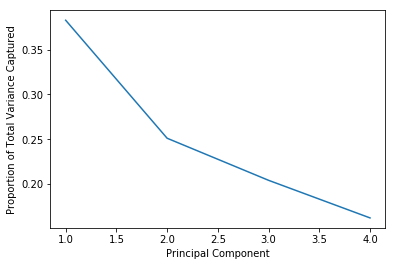

In [180]:
x = np.arange(1,all_pca_data.shape[1]+1)
var = [variance_captured(s, xi) for xi in x]
plt.plot(x, var);
plt.xlabel('Principal Component');
plt.ylabel('Proportion of Total Variance Captured');

In [181]:
print('Number of PCs\tVariance captured')
for i in range(1, all_pca_data.shape[1]+1):
    print(i,'\t\t',round(variance_captured_first_k(s,i),4))

Number of PCs	Variance captured
1 		 0.3827
2 		 0.6337
3 		 0.8378
4 		 1.0


Examine the weights of the PCs

In [182]:
weights = pd.DataFrame({'Var':all_pca_data.columns,
                       'PC1 weights':np.array(vt[0,:])[0],
                       'PC2 weights':np.array(vt[1,:])[0]
                       }).set_index('Var')
weights.sort_values('PC1 weights')

,PC1 weights,PC2 weights
Var,,
travel_time,0.503989,-0.120322
infant_mort,0.503989,-0.120322
val_prod,0.503989,-0.120322
val_prod_per_ha,0.503989,-0.120322


FLAG: KW fix this, these shouldn't all be the same value..

## Visualize the Cleaned Raster Images and Data Columns

In [204]:
pca_data

,path,raster,metadata,masked,band,df,cleaned_df,processed,pca_df
travel_time,data/raw_data/TravelTime_50k/Traveltime_50k.tif,<open DatasetReader name='data/raw_data/Travel...,"[driver, dtype, nodata, width, height, count, ...",<open DatasetReader name='data/raw_data/Travel...,"[[-3.4028235e+38, -3.4028235e+38, -3.4028235e+...",0 1 2 ...,0 1 2 3 4 5 6 7 8...,<open DatasetReader name='data/raw_data/Travel...,"travel_time coords 0,0 ..."
val_prod,data/raw_data/val_prod.tif,<open DatasetReader name='data/raw_data/val_pr...,"[driver, dtype, nodata, width, height, count, ...",<open DatasetReader name='data/raw_data/val_pr...,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",0 1 2 3 4 5 6 7 8...,0 1 2 3 4 5 6 7 8...,<open DatasetReader name='data/raw_data/val_pr...,"val_prod coords 0,0 ..."
val_prod_per_ha,data/raw_data/val_prod_per_ha.tif,<open DatasetReader name='data/raw_data/val_pr...,"[driver, dtype, nodata, width, height, count, ...",<open DatasetReader name='data/raw_data/val_pr...,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",0 1 2 3 4 5 6 7 8...,0 1 2 3 4 5 6 7 8...,<open DatasetReader name='data/raw_data/val_pr...,val_prod_per_ha coords ...


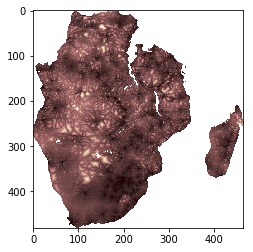

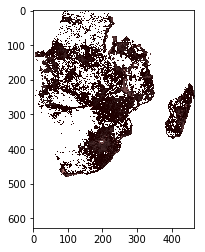

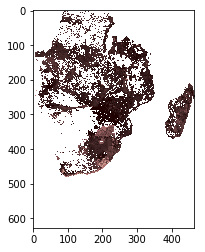

In [205]:
for name in pca_data_names:
    pyplot.imshow(pca_data.loc[name,'processed'].read(1), cmap='pink')
    pyplot.savefig(name+'_proc.png')
    pyplot.show()

KeyboardInterrupt: 

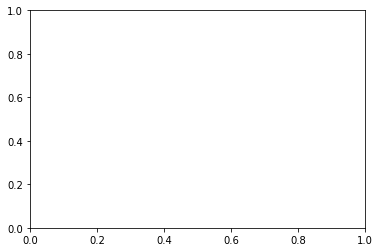

In [183]:
for name in pca_data_names:
    pca_data.loc[name,'pca_df'].iloc[:,0].plot.kde()
    pyplot.savefig(name+'_kde.png')

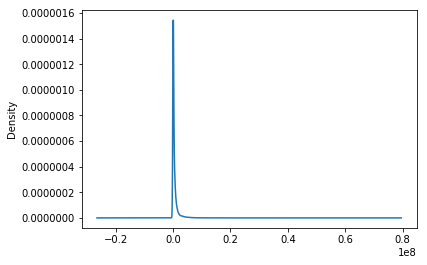

In [158]:
pca_data.loc['val_prod','pca_df'].iloc[:,0].plot.kde()

# EXTRA

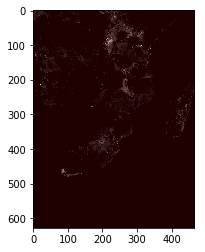

In [56]:
val_prod_band = val_prod_masked.read(1)

pyplot.show()

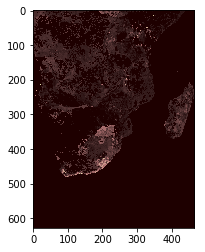

In [57]:
pyplot.imshow(val_prod_per_hect_masked.read(1), cmap='pink')

pyplot.show()

In [81]:
val_prod_per_hect_band = val_prod_per_hect_masked.read(1)
pd.DataFrame(val_prod_per_hect_band).shape

(628, 466)

In [116]:
travel_time_df_sub.pyplot.scatter()

AttributeError: 'DataFrame' object has no attribute 'pyplot'

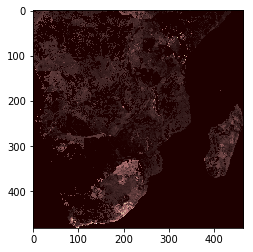

In [118]:
pyplot.imshow(val_prod_per_hect_df_sub, cmap='pink')

pyplot.show()

In [108]:
val_prod_df_sub.shape

(482, 466)

In [58]:
# check each dataset's upper left and lower right coordinates
# these coordinates are meters from the origin of the coordinate system
for dataset in raster_data_masked:
    print(str(dataset.name))
    print(dataset.transform*(0,0))
    print(dataset.transform*(dataset.width, dataset.height))
# FLAG: the bounds are not the same for each dataset. 

data/raw_data/TravelTime_50k/Traveltime_50k_mask.tif
(11.666666666988416, 5.3333333332066)
(50.5000000003062, -34.833333333444)
data/raw_data/PovMap_Global_Infant_Mortality/povmap_global_subnational_infant_mortality_rates_v2_mask.tif
(11.716666666666612, 5.318778284000032)
(50.48333333333326, -46.96455504933328)
data/raw_data/val_prod_mask.tif
(11.665900000000022, 5.333671999999993)
(50.499078000000026, -46.99945200000001)
data/raw_data/val_prod_per_ha_mask.tif
(11.665900000000022, 5.333671999999993)
(50.499078000000026, -46.99945200000001)
